# Preparación final para modelado estadístico

## 1. Cargar serie temporal

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Cargar serie temporal
ruta_csv = "../data/processed/serie_temporal.csv"
serie = pd.read_csv(ruta_csv)     
# Estilo para los graficos
plt.style.use("seaborn-v0_8")

In [18]:
serie["timestamp"] = pd.to_datetime(serie["timestamp"])
serie = serie.set_index("timestamp")
serie.head()

,total_pkts,total_bytes,flow_bytes/s,flow_packets/s,flow_iat_mean,active_mean,idle_mean,num_ddos_flows,pkts_rate,bytes_rate,pkts_per_flow
timestamp,,,,,,,,,,,
2017-07-07 03:30:00,43583,35186405,inf,inf,6.884039e+05,118579.151464,3.247528e+06,0,726.383333,586440.083333,4.358300e+10
2017-07-07 03:31:00,27517,15873318,inf,inf,6.860297e+05,71027.774723,3.335710e+06,0,458.616667,264555.300000,2.751700e+10
2017-07-07 03:32:00,3899,1760887,4.675717e+06,9.102111e+04,6.338513e+05,33379.712885,4.343144e+06,0,64.983333,29348.116667,3.899000e+09
2017-07-07 03:33:00,16056,6351927,1.380671e+06,4.350707e+04,1.073293e+06,129475.865941,4.494442e+06,0,267.600000,105865.450000,1.605600e+10
2017-07-07 03:34:00,10606,5452445,1.349385e+06,4.824574e+04,6.350480e+05,40147.639813,2.939384e+06,0,176.766667,90874.083333,1.060600e+10


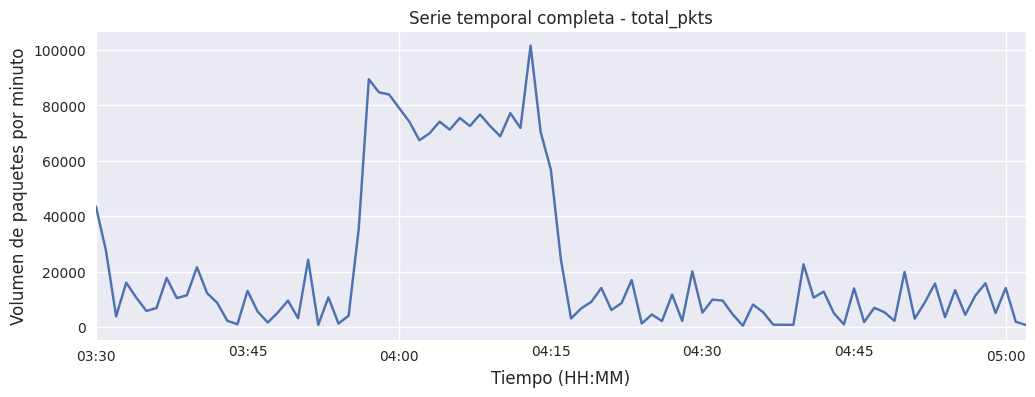

In [19]:
col_metrica = "total_pkts"  

serie[col_metrica].plot(figsize=(12, 4))
plt.title("Serie temporal completa - " + col_metrica)
plt.xlabel("Tiempo (HH:MM)", fontsize=12)
plt.ylabel("Volumen de paquetes por minuto", fontsize=12)
plt.show()

### 2. Definición de ventana de tráfico benigno

El tramo de tráfico benigno corresponde al intervalo de tiempo previo al inicio del ataque DDoS contenido en la captura *Friday Afternoon* del dataset CICIDS2017. 

✅ Gráfico exportado a: ../results/12_ventana_benigna_delimitacion.png


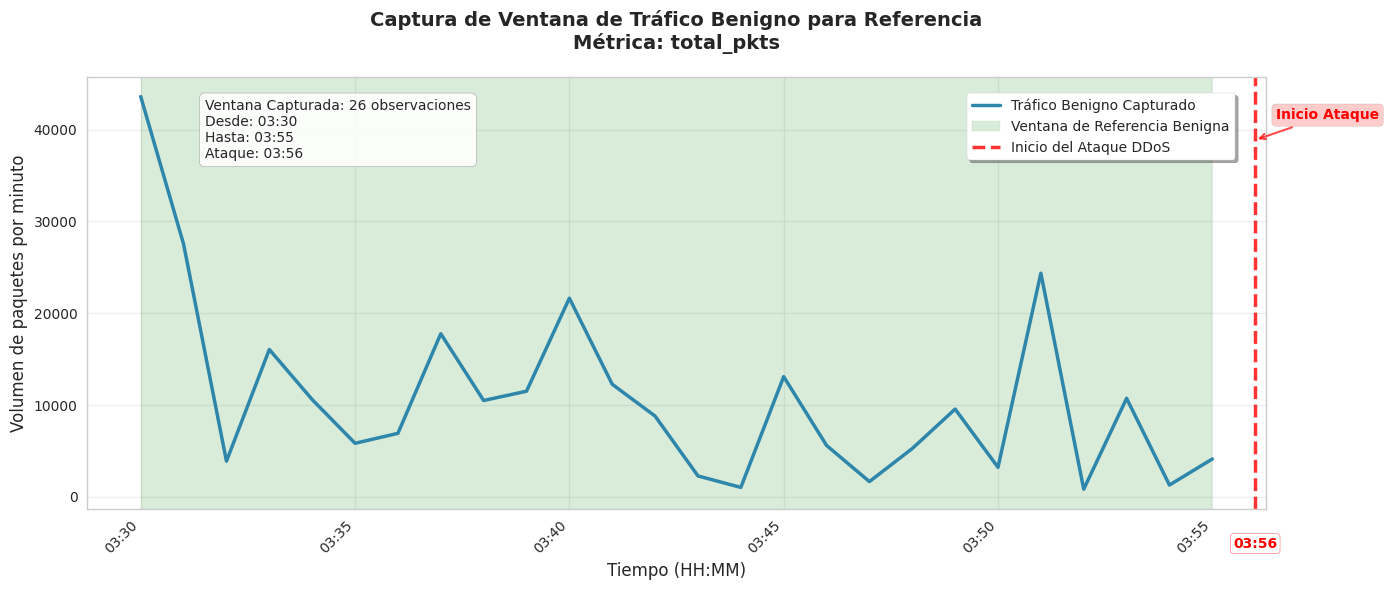

In [20]:
plt.style.use('seaborn-v0_8-whitegrid')

inicio_ataque = serie[serie["num_ddos_flows"] > 0].index.min()
serie_benigna = serie[serie.index < inicio_ataque].copy()

fig, ax = plt.subplots(figsize=(14, 6))

# Gráfico principal del tráfico benigno
ax.plot(serie_benigna.index, serie_benigna[col_metrica], 
        color='#2E86AB', linewidth=2.5, label='Tráfico Benigno Capturado')

# Área sombreada que delimita claramente la ventana de referencia
ax.axvspan(serie_benigna.index.min(), serie_benigna.index.max(), 
          alpha=0.15, color='green', label='Ventana de Referencia Benigna')

# Línea vertical que marca el inicio del ataque
ax.axvline(x=inicio_ataque, color='red', linestyle='--', linewidth=2.5,
          label='Inicio del Ataque DDoS', alpha=0.8)

# Formateo del eje temporal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, ha='right')

# Títulos y etiquetas
ax.set_title("Captura de Ventana de Tráfico Benigno para Referencia\n" +
            f"Métrica: {col_metrica}", 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Tiempo (HH:MM)", fontsize=12)
ax.set_ylabel("Volumen de paquetes por minuto",fontsize=12)

# LEYENDA en posición esquina superior derecha
legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True,
                  bbox_to_anchor=(0.98, 0.98))

ax.grid(True, alpha=0.3)

# ANOTACIÓN para entregar información en el gráfico
ax.annotate(f'Ventana Capturada: {len(serie_benigna)} observaciones\n' +
           f'Desde: {serie_benigna.index.min().strftime("%H:%M")}\n' +
           f'Hasta: {serie_benigna.index.max().strftime("%H:%M")}\n' +
           f'Ataque: {inicio_ataque.strftime("%H:%M")}',
           xy=(0.10, 0.95), xycoords='axes fraction',  # MISMA ALTURA (0.98)
           bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9,
                   edgecolor='gray'),
           fontsize=10, verticalalignment='top')

# ETIQUETA FLOTANTE CON FLECHA para el inicio del ataque
ax.annotate('Inicio Ataque', 
           xy=(inicio_ataque, ax.get_ylim()[1] * 0.85),
           xytext=(15, 15), textcoords='offset points',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.2),
           arrowprops=dict(arrowstyle='->', color='red', alpha=0.7, lw=1.5),
           fontsize=10, color='red', fontweight='bold', ha='left')

# ETIQUETA DE HORA BAJO LA LÍNEA
ax.annotate(f'{inicio_ataque.strftime("%H:%M")}', 
           xy=(inicio_ataque, ax.get_ylim()[0]),
           xytext=(0, -20), textcoords='offset points',
           fontsize=10, color='red', fontweight='bold', 
           ha='center', va='top',
           bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8,
                   edgecolor='red'))

# Ajustar layout
plt.tight_layout()

# Exportar
ruta_opcion1 = "../results/12_ventana_benigna_delimitacion.png"
plt.savefig(ruta_opcion1, dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Gráfico exportado a:", ruta_opcion1)

plt.show()

## 3. Estacionariedad en la ventana de tráfico benigno

Gráfico exportado exitosamente a:  ../results/13_estacionariedad_ventana_trafico_benigno_PACF.png


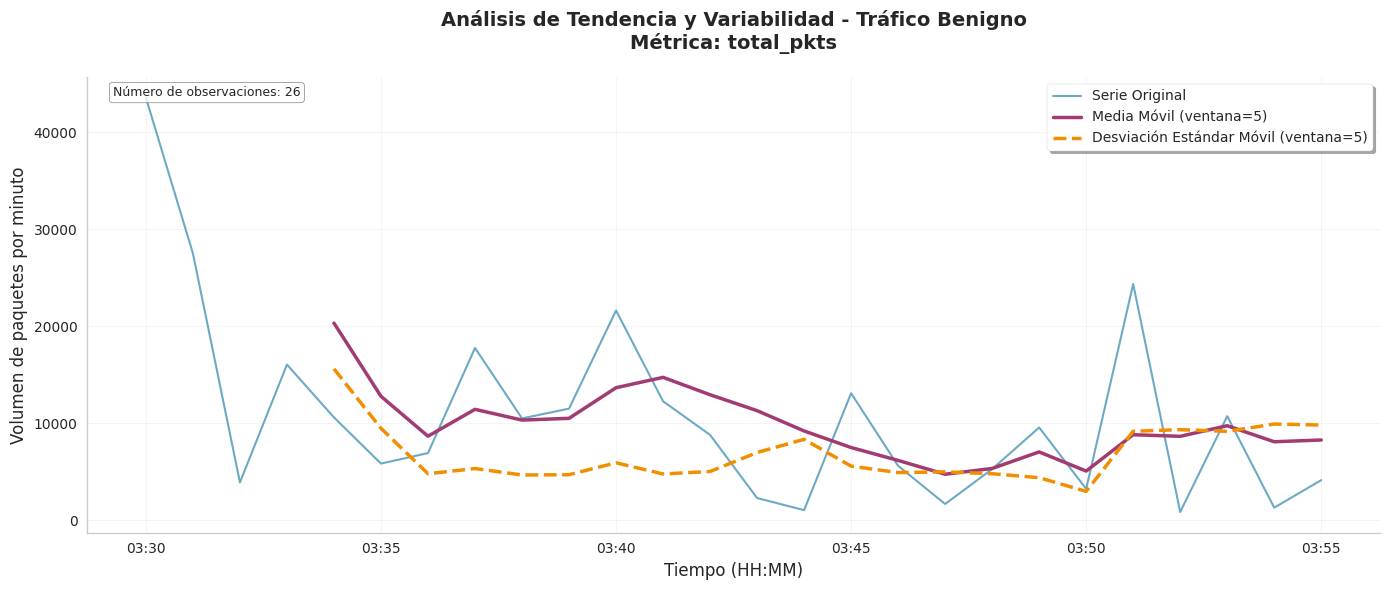


📊 Estadísticas Resumen - total_pkts
Media global: 10773.54
Desviación estándar global: 9862.39
Media móvil final: 8277.40
Desviación estándar móvil final: 9819.90


In [21]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 6))

window = 5
rolling_mean = serie_benigna[col_metrica].rolling(window).mean()
rolling_std = serie_benigna[col_metrica].rolling(window).std()

# Crear el gráfico
line_original = ax.plot(serie_benigna.index, serie_benigna[col_metrica], 
                       label="Serie Original", 
                       color='#2E86AB', 
                       alpha=0.7, 
                       linewidth=1.5)

line_mean = ax.plot(rolling_mean.index, rolling_mean, 
                   label=f"Media Móvil (ventana={window})", 
                   color='#A23B72', 
                   linewidth=2.5, 
                   linestyle='-')

line_std = ax.plot(rolling_std.index, rolling_std, 
                  label=f"Desviación Estándar Móvil (ventana={window})", 
                  color='#F18F01', 
                  linewidth=2.5, 
                  linestyle='--')

# Formatear el eje x para mostrar horas y minutos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


ax.set_title(f"Análisis de Tendencia y Variabilidad - Tráfico Benigno\n"
            f"Métrica: {col_metrica}", 
            fontsize=14, 
            fontweight='bold', 
            pad=20)

ax.set_xlabel("Tiempo (HH:MM)", fontsize=12, fontweight='normal')
ax.set_ylabel("Volumen de paquetes por minuto", fontsize=12, fontweight='normal')

# Mejorar la leyenda
legend = ax.legend(loc='upper right', 
                  frameon=True, 
                  fancybox=True, 
                  shadow=True, 
                  fontsize=10)

# Configurar grid y spines
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Formatear ejes
ax.tick_params(axis='both', which='major', labelsize=10)

# Añadir anotación informativa si es necesario
if len(serie_benigna) > 0:
    ax.annotate(f'Número de observaciones: {len(serie_benigna)}', 
               xy=(0.02, 0.98), 
               xycoords='axes fraction', 
               fontsize=9, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
               verticalalignment='top')

plt.tight_layout()

# Exportar el gráfico
ruta = "../results/13_estacionariedad_ventana_trafico_benigno_PACF.png"
plt.savefig(ruta, dpi = 300, bbox_inches = 'tight',facecolor = 'white',edgecolor = 'none')

print("Gráfico exportado exitosamente a: ", ruta)
plt.show()

# Opcional: Mostrar estadísticas resumen
print(f"\n📊 Estadísticas Resumen - {col_metrica}")
print(f"Media global: {serie_benigna[col_metrica].mean():.2f}")
print(f"Desviación estándar global: {serie_benigna[col_metrica].std():.2f}")
print(f"Media móvil final: {rolling_mean.iloc[-1]:.2f}")
print(f"Desviación estándar móvil final: {rolling_std.iloc[-1]:.2f}")

### Prueba ADF (Augmented Dickey-Fuller)

In [22]:
adf_result = adfuller(serie_benigna[col_metrica].dropna())

adf_stat = adf_result[0]
p_value = adf_result[1]
lags_used = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]

print(f"Estadístico ADF: {adf_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Número de rezagos usados: {lags_used}")
print(f"Número de observaciones usadas: {n_obs}")
print("Valores críticos:")
for key, value in critical_values.items():
    print(f"   {key}: {value:.4f}")

Estadístico ADF: -5.4825
p-value: 0.0000
Número de rezagos usados: 0
Número de observaciones usadas: 25
Valores críticos:
   1%: -3.7239
   5%: -2.9865
   10%: -2.6328


### Prueba KPSS (Kwiatkowski–Phillips–Schmidt–Shin)

In [28]:
serie_kpss = serie_benigna[col_metrica].dropna()
kpss_stat, p_value, lags_used, critical_values = kpss(serie_kpss, regression='c', nlags=3)#auto

print(f"Estadístico KPSS: {kpss_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Número de rezagos utilizados: {lags_used}")
print("Valores críticos (KPSS):")
for key, value in critical_values.items():
    print(f"   {key}: {value:.4f}")

if p_value > 0.05:
    print("No se rechaza H0: la serie es ESTACIONARIA (según KPSS).")
else:
    print("Se rechaza H0: la serie NO es estacionaria (según KPSS).")

Estadístico KPSS: 0.4748
p-value: 0.0473
Número de rezagos utilizados: 3
Valores críticos (KPSS):
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
Se rechaza H0: la serie NO es estacionaria (según KPSS).


## 4. Construcción de la serie preparada

In [26]:
serie_preparada = serie[col_metrica].copy()
serie_preparada.head()

timestamp
2017-07-07 03:30:00    43583
2017-07-07 03:31:00    27517
2017-07-07 03:32:00     3899
2017-07-07 03:33:00    16056
2017-07-07 03:34:00    10606
Name: total_pkts, dtype: int64

In [27]:
# Exportar la serie temporal para utilizar en ARIMA y Holt-Winters
path_salida = "../data/processed/serie_preparada.csv"

serie_preparada.to_csv(path_salida, index=True)
print("Serie temporal exportada correctamente a: ", path_salida)

Serie temporal exportada correctamente a:  ../data/processed/serie_preparada.csv
